In [48]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from itertools import *
from sklearn.cluster import KMeans

In [2]:
def show(image, cmap='gray'):
    plt.imshow(image, cmap=cmap)
    plt.show()
    
def export(imagename):
    cv2.imwrite(imagename+".jpg", eval(imagename))
    
kernel = np.ones((7,7),np.uint8)
kernel_bigger = np.ones((50,50),np.uint8)
kernel_even_bigger = np.ones((5,1000),np.uint8)

padding_size = 10

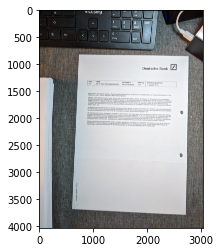

In [3]:
img00 = cv2.imread("img00.jpg")
show(img00)

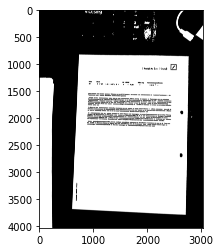

In [4]:
img01 = cv2.cvtColor(img00, cv2.COLOR_BGR2GRAY)
ret,img01 = cv2.threshold(img01, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
img01 = cv2.morphologyEx(img01, cv2.MORPH_OPEN, kernel)
img01 = cv2.morphologyEx(img01, cv2.MORPH_CLOSE, kernel)
show(img01)

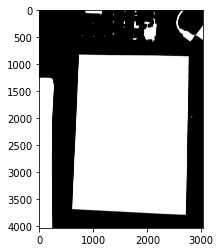

In [5]:
img02 = cv2.morphologyEx(img01, cv2.MORPH_CLOSE, kernel_bigger)
show(img02)

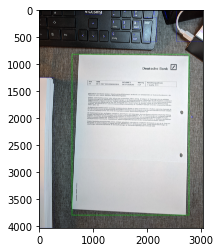

In [6]:
img03 = img00.copy()
bounding_boxes = list()

contours = cv2.findContours(img02, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for c in contours[0]:
    x,y,w,h = cv2.boundingRect(c)
    bounding_boxes.append(np.array([x, y, x+w, y+h, w*h]))
    cv2.rectangle(img03, (x, y), (x + w, y + h), (0,0,255), 2)
    
bb_index = np.argmax(np.array(bounding_boxes)[:,4])
bb = bounding_boxes[bb_index]

cv2.rectangle(img03, (bb[0], bb[1]), (bb[2], bb[3]), (0,255,0), 2)

bbwp = bb[:4].copy()
bbwp[0] = bbwp[0] - padding_size
bbwp[1] = bbwp[1] - padding_size
bbwp[2] = bbwp[2] + padding_size
bbwp[3] = bbwp[3] + padding_size

cv2.rectangle(img03, (bbwp[0], bbwp[1]), (bbwp[2], bbwp[3]), (0,255,0), 2)
    
show(img03)

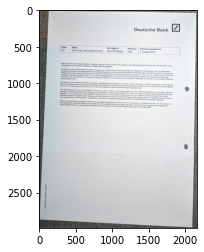

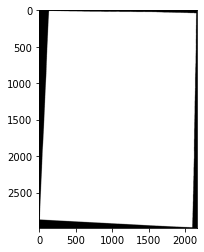

In [7]:
img04 = img00[bbwp[1]:bbwp[3], bbwp[0]:bbwp[2]]
img05 = img02[bbwp[1]:bbwp[3], bbwp[0]:bbwp[2]]
img05 = cv2.morphologyEx(img05, cv2.MORPH_CLOSE, kernel)
show(img04)
show(img05)

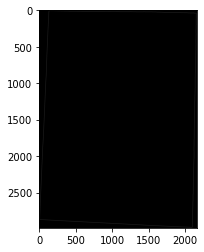

In [8]:
img06 = cv2.Canny(img05, 127, 255)
show(img06)

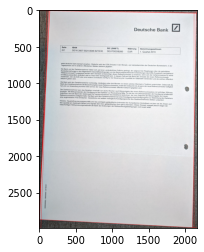

In [67]:
img07 = img04.copy()

lines = cv2.HoughLines(img06,1,np.pi/180,200)
for line in lines:
    rho, theta = line[0]
    a, b = np.cos(theta), np.sin(theta)
    x0, y0 = a * rho, b * rho
    n = 5000
    x1 = int(x0 + n * (-b))
    y1 = int(y0 + n * (a))
    x2 = int(x0 - n * (-b))
    y2 = int(y0 - n * (a))

    cv2.line(
        img07, 
        (x1, y1), 
        (x2, y2), 
        (255, 0, 0), 
        2
    )

show(img07)

In [47]:
intersection_points = list()

for i,j in combinations(range(len(lines)),2):
    rho1, theta1 = lines[i][0]
    rho2, theta2 = lines[j][0]
    
    m1 = -(np.cos(theta1) / np.sin(theta1))
    m2 = -(np.cos(theta2) / np.sin(theta2))
    if not 80.0 < abs(np.math.atan(abs(m2-m1) / (1 + m2 * m1))) * (180 / np.pi) < 100.0:
        continue
    
    A = np.array([
      [np.cos(theta1), np.sin(theta1)],
      [np.cos(theta2), np.sin(theta2)]
    ])
    
    b = np.array([[rho1], [rho2]])
    x0, y0 = np.linalg.solve(A, b)
    x0, y0 = int(np.round(x0)), int(np.round(y0))
    
    if x0 < 0 or x0 > img07.shape[1] or y0 < 0 or y0 > img07.shape[0]:
        continue
    
    intersection_points.append(np.array([x0, y0]))
    
intersection_points = np.array(intersection_points)
print(intersection_points)

[[2105 2978]
 [  29 2869]
 [   9 2868]
 [2157   45]
 [2157   40]
 [ 149   10]
 [ 129    9]
 [ 109    9]
 [ 144   10]
 [ 149    5]
 [ 129    4]
 [ 109    4]
 [ 144    5]]


<ipython-input-47-4f98f55e95e1>:8: RuntimeWarning: divide by zero encountered in float_scalars
  m2 = -(np.cos(theta2) / np.sin(theta2))
<ipython-input-47-4f98f55e95e1>:9: RuntimeWarning: invalid value encountered in true_divide
  if not 80.0 < abs(np.math.atan(abs(m2-m1) / (1 + m2 * m1))) * (180 / np.pi) < 100.0:


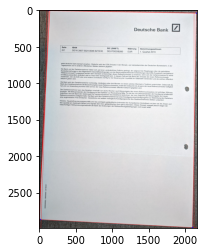

In [68]:
kmeans = KMeans(n_clusters = 4, 
                init = 'k-means++', 
                max_iter = 100, 
                n_init = 10, 
                random_state = 0).fit(intersection_points)
corners = kmeans.cluster_centers_

img08 = img07.copy()
for corner in corners:
    x, y = corner
    cv2.circle(img08, (int(x), int(y)), 5, (0, 0, 255), 5)
    
show(img08)

In [69]:
# export("img00")  # because why would I?
export("img01")
export("img02")
export("img03")
export("img04")
export("img05")
export("img06")
export("img07")
export("img08")